Feature Extraction and Testing and Training set Creation.

In [2]:
import numpy as np 
import pandas as pd 
import librosa 
import os
from sklearn.model_selection import train_test_split
import sklearn
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import CSVLogger
from sklearn.preprocessing import OneHotEncoder
#from keras.callbacks import CSVLogger

#from keras.callbacks import CSVLogger

In [3]:
def plot(x, sr):
    # Waveplot
    plt.figure(figsize=(20, 5))
    plt.title("Waveplot")
    librosa.display.waveplot(x, sr = sr)

    # Spectrogram
    X = librosa.stft(x) # stft is Short time fourier transformation
    Xdb = librosa.amplitude_to_db(abs(X)) # Coverting amplitude to decibel
    plt.figure(figsize=(20, 5))
    plt.title("Spectrogram")
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

    # mfcc
    plt.figure(figsize=(20, 5))
    plt.title("MFCC")
    mfccs = librosa.feature.mfcc(x, sr = sr)
    librosa.display.specshow(mfccs, sr = sr, x_axis='time')

In [ ]:

    # Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

    # Vocal channel (01 = speech, 02 = song).

    # Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

    # Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

    # Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

    # Repetition (01 = 1st repetition, 02 = 2nd repetition).

    # Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


We will traverse through all the files and create a data frame containg Actor,Gender, Emotion and File Path for each audio files. Then we will use this dataframe to go through all the file path and get the mean mfccs values for each audio file. This mfcc value extracted for each audio file is used to train the model based on emotion associated with each audio file. 

In [4]:
emotion=[]
gender=[]
actor=[]
file_path=[]
for i in os.listdir('/home/gauravk/Desktop/BCS_SER/archive'):
    # print(i)
    for j in os.listdir('/home/gauravk/Desktop/BCS_SER/archive/'+i):
        # print(j)
        part = j.split('.')[0].split('-')
        #print(part[2])
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        if int(part[6])%2:
            gender.append('male')
        else:
            gender.append("female")
        file_path.append('/home/gauravk/Desktop/BCS_SER/archive/' + i + '/' + j)

# A dataframe containing all emotion, gender, actor, path
new_df = pd.DataFrame(emotion)
new_df = new_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
new_df = pd.concat([pd.DataFrame(gender), new_df,pd.DataFrame(actor)], axis=1)
new_df.columns = ['gender','emotion','actor']
new_df = pd.concat([new_df, pd.DataFrame(file_path, columns = ['path'])],axis=1)
print(new_df)


      gender   emotion  actor  \
0       male     angry     21   
1       male      fear     21   
2       male       sad     21   
3       male     happy     21   
4       male       sad     21   
...      ...       ...    ...   
1435  female     angry     20   
1436  female     happy     20   
1437  female     happy     20   
1438  female      fear     20   
1439  female  surprise     20   

                                                   path  
0     /home/gauravk/Desktop/BCS_SER/archive/Actor_21...  
1     /home/gauravk/Desktop/BCS_SER/archive/Actor_21...  
2     /home/gauravk/Desktop/BCS_SER/archive/Actor_21...  
3     /home/gauravk/Desktop/BCS_SER/archive/Actor_21...  
4     /home/gauravk/Desktop/BCS_SER/archive/Actor_21...  
...                                                 ...  
1435  /home/gauravk/Desktop/BCS_SER/archive/Actor_20...  
1436  /home/gauravk/Desktop/BCS_SER/archive/Actor_20...  
1437  /home/gauravk/Desktop/BCS_SER/archive/Actor_20...  
1438  /home/gauravk/Des

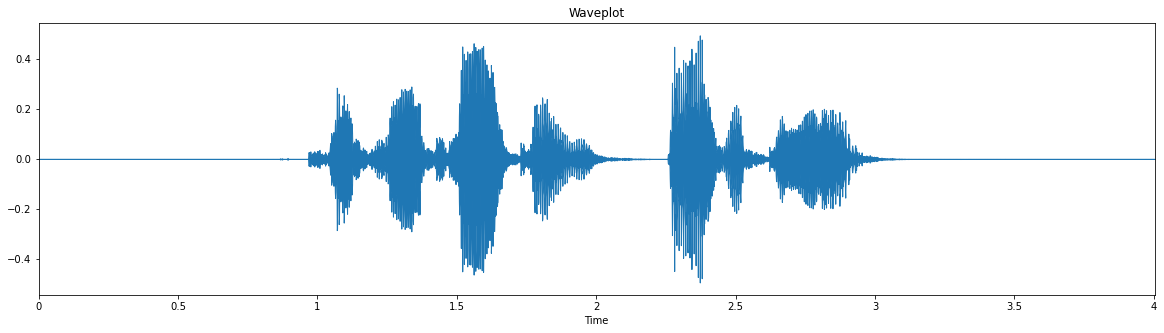

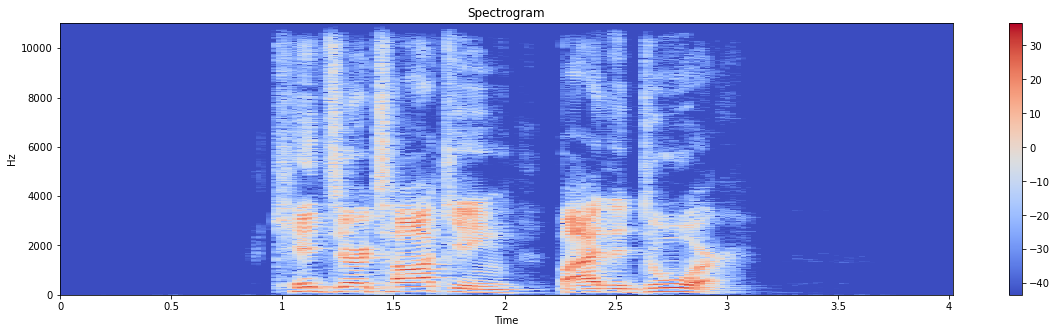

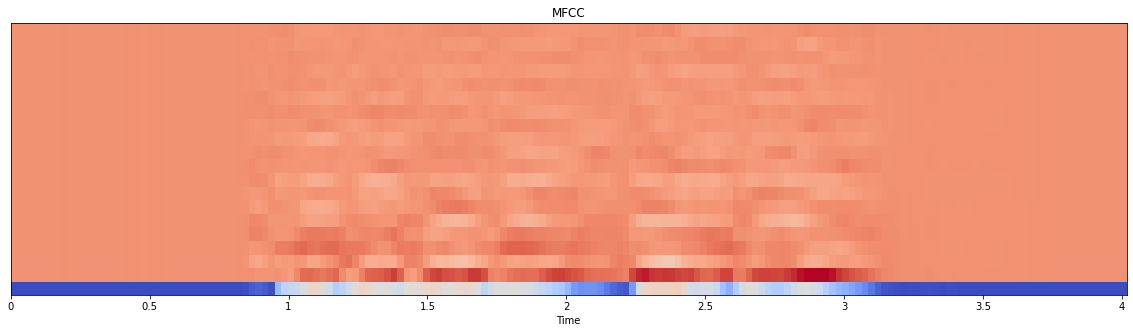

In [5]:
# Plot Waveform, Spectrogram, MFCC of First Audio
x, sr = librosa.load(new_df['path'][0])
plot(x, sr)

MFCC values for each audio file is extracted here. Generally, librosa.feature.mfcc returns us the mfcc of each audio file and is of shape 20 x 143 . So taking mean for each row using np.mean we get 20 mean mfcc values associated with each audio file. These 20 MFCC value will be used as training parameter.

In [6]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT MFCC
# New df with column name 'MFCC'
df = pd.DataFrame(columns=['MFCC'])
count=0
for path in new_df.path:
    # Load audio and set the duration to 2.75sec so that we get MFCC array of same shape
    X, sample_rate = librosa.load(path, duration=2.75)
    # MFCC
    # n_fcc is for number of properties in MFCC array
    mfccs = librosa.feature.mfcc(X, sr = sample_rate, hop_length=512, n_mfcc=20)
    # Get the mean of columns
    mean = np.mean(mfccs.T, axis = 0)
    df.loc[count] = [mean]

    count = count+1
df.head()

,MFCC
0,"[-400.46616, 52.861126, -19.815674, 20.267315,..."
1,"[-509.50345, 76.690895, -8.484779, 20.890457, ..."
2,"[-618.5289, 62.47535, 6.8694706, 23.727352, 7...."
3,"[-423.6228, 69.64247, -22.366869, 15.676978, 3..."
4,"[-634.855, 65.04783, 7.7638574, 24.427826, 8.1..."


In [7]:
df['MFCC'].shape, df['MFCC'][0].shape

((1440,), (20,))

There are 1440 audio files so we get total ((1440,),(20,)) total as our dataset.  Now we combine this df with existing data frame containing other details of audio files. As we are training on mfccs values so that acts as X(input parameter) based on it's corresponding emotions values so this will act as Y(output parameter). We have divided train and test data in 0.7 : 0.3 ratio. 

In [8]:
# df contains MFCC column and audio_df which contains other labels
combined_df = pd.concat([new_df, df], axis=1)
combined_df.head()

# Dividing dataset in training and testing set
train_X, test_X, train_y, test_y = train_test_split(combined_df['MFCC'], combined_df['emotion'], test_size=0.3, random_state=0)

train_X=pd.DataFrame(train_X.values.tolist())
test_X=pd.DataFrame(test_X.values.tolist())
print(train_X.shape,test_X.shape,train_y.shape,test_y.shape)


(1008, 20) (432, 20) (1008,) (432,)


Data Preprocessing

In [9]:
# Normalize Data
mean = np.mean(train_X, axis=0)
#print(mean.shape)
std = np.std(train_X, axis=0)
train_X = (train_X - mean)/std
test_X = (test_X - mean)/std

#np array
train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)
print(train_X.shape,test_X.shape,train_y.shape,test_y.shape)

#one_hot encode
encoder = OneHotEncoder()
train_y = np.array(train_y).reshape(-1,1)
test_y = np.array(test_y).reshape(-1,1)
train_y= encoder.fit_transform(train_y).toarray()
test_y = encoder.fit_transform(test_y).toarray()
print(train_X.shape,test_X.shape,train_y.shape,test_y.shape)

#scaler fit
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)
print(train_X.shape,test_X.shape,train_y.shape,test_y.shape)


(1008, 20) (432, 20) (1008,) (432,)
(1008, 20) (432, 20) (1008, 8) (432, 8)
(1008, 20) (432, 20) (1008, 8) (432, 8)


In [10]:
#to plot

def plot_history(history):
  # function to plot accuracy vs epoch
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')



Now we will define a model, and then run the model on the test train set we have created

In [11]:
def build_mlp_model(input_shape=(20,), num_class=8):
    
    
    model=keras.models.Sequential([keras.layers.Dropout(0.1),
                                    keras.layers.Dense(512,activation='relu',input_shape=(train_X.shape[1],)),#,kernel_regularizer=tf.keras.regularizers.l2(1e-2)),
                                    keras.layers.Dropout(0.1),
                                    keras.layers.Dense(512,activation='relu'),#,kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
                                    keras.layers.Dropout(0.1),
                                    keras.layers.Dense(128,activation='relu'),
                                    keras.layers.Dense(64,activation='relu'),
                                    keras.layers.Dense(train_y.shape[1],activation='softmax')
                                    ])

    return model

First we will train this MLP model on 'categorical_crossentropy'as loss function, and 'adam' as optimizer and check the accuaracy.

In [14]:
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)
model=build_mlp_model()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
csv_logger = CSVLogger('model_history.log', separator=',', append=False)

history=model.fit(train_X,train_y,epochs=1000,batch_size=256,validation_data=(test_X,test_y),callbacks=[csv_logger])
model.summary()


(1008, 20) (1008, 8) (432, 20) (432, 8)
Epoch 1/1000
4/4 [==============================] - 0s 42ms/step - loss: 2.0466 - accuracy: 0.1577 - val_loss: 1.9315 - val_accuracy: 0.2870
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8919 - accuracy: 0.2748 - val_loss: 1.7917 - val_accuracy: 0.3426
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.7594 - accuracy: 0.3452 - val_loss: 1.6596 - val_accuracy: 0.3981
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.6405 - accuracy: 0.3948 - val_loss: 1.5879 - val_accuracy: 0.4352
Epoch 5/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.5658 - accuracy: 0.4067 - val_loss: 1.5039 - val_accuracy: 0.4444
Epoch 6/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.4777 - accuracy: 0.4474 - val_loss: 1.4526 - val_accuracy: 0.4722
Epoch 7/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.4473 - accuracy: 0.4583 - val_loss: 1.4

4/4 [==============================] - 0s 14ms/step - loss: 0.5550 - accuracy: 0.8264 - val_loss: 0.9431 - val_accuracy: 0.6667
Epoch 59/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5353 - accuracy: 0.8185 - val_loss: 0.9864 - val_accuracy: 0.6551
Epoch 60/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5714 - accuracy: 0.8046 - val_loss: 0.9863 - val_accuracy: 0.6458
Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4957 - accuracy: 0.8333 - val_loss: 0.9633 - val_accuracy: 0.6736
Epoch 62/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5057 - accuracy: 0.8194 - val_loss: 0.9681 - val_accuracy: 0.6667
Epoch 63/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4951 - accuracy: 0.8304 - val_loss: 0.9712 - val_accuracy: 0.6806
Epoch 64/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5293 - accuracy: 0.8204 - val_loss: 0.9456 - val_accuracy: 0.6875
Epoch 65/1000
4/4 [=

Epoch 116/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3516 - accuracy: 0.8859 - val_loss: 1.0096 - val_accuracy: 0.6551
Epoch 117/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3705 - accuracy: 0.8810 - val_loss: 1.0148 - val_accuracy: 0.6644
Epoch 118/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3151 - accuracy: 0.8998 - val_loss: 0.9585 - val_accuracy: 0.6875
Epoch 119/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3529 - accuracy: 0.8780 - val_loss: 0.9597 - val_accuracy: 0.6782
Epoch 120/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3303 - accuracy: 0.8978 - val_loss: 0.9566 - val_accuracy: 0.6806
Epoch 121/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3183 - accuracy: 0.8948 - val_loss: 1.0084 - val_accuracy: 0.6736
Epoch 122/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3161 - accuracy: 0.8968 - val_loss: 0.9945 - val_accuracy: 0.6875

4/4 [==============================] - 0s 11ms/step - loss: 0.2621 - accuracy: 0.9167 - val_loss: 1.0126 - val_accuracy: 0.6759
Epoch 174/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2248 - accuracy: 0.9246 - val_loss: 1.0404 - val_accuracy: 0.6667
Epoch 175/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2378 - accuracy: 0.9196 - val_loss: 0.9894 - val_accuracy: 0.6898
Epoch 176/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2646 - accuracy: 0.9167 - val_loss: 0.9851 - val_accuracy: 0.6806
Epoch 177/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2512 - accuracy: 0.9226 - val_loss: 0.9921 - val_accuracy: 0.6644
Epoch 178/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2572 - accuracy: 0.9147 - val_loss: 0.9940 - val_accuracy: 0.6667
Epoch 179/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2521 - accuracy: 0.9187 - val_loss: 1.0294 - val_accuracy: 0.6713
Epoch 180/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2394 - accuracy: 0.9177 - val_loss: 1.0849 - val_accuracy: 0.6713
Epoch 231/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1874 - accuracy: 0.9395 - val_loss: 1.1413 - val_accuracy: 0.6644
Epoch 232/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2040 - accuracy: 0.9296 - val_loss: 1.0956 - val_accuracy: 0.6574
Epoch 233/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1924 - accuracy: 0.9335 - val_loss: 1.0987 - val_accuracy: 0.6736
Epoch 234/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2139 - accuracy: 0.9296 - val_loss: 1.0854 - val_accuracy: 0.6806
Epoch 235/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2082 - accuracy: 0.9325 - val_loss: 1.0698 - val_accuracy: 0.6921
Epoch 236/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1881 - accuracy: 0.9375 - val_loss: 1.0989 - val_accuracy: 0.6782
Epoch 237/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.1645 - accuracy: 0.9444 - val_loss: 1.0631 - val_accuracy: 0.6829
Epoch 288/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1542 - accuracy: 0.9534 - val_loss: 1.0432 - val_accuracy: 0.6852
Epoch 289/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1597 - accuracy: 0.9504 - val_loss: 1.0886 - val_accuracy: 0.6667
Epoch 290/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1998 - accuracy: 0.9325 - val_loss: 1.1047 - val_accuracy: 0.6644
Epoch 291/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1873 - accuracy: 0.9375 - val_loss: 1.1292 - val_accuracy: 0.6782
Epoch 292/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1818 - accuracy: 0.9405 - val_loss: 1.1155 - val_accuracy: 0.6806
Epoch 293/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1676 - accuracy: 0.9494 - val_loss: 1.0959 - val_accuracy: 0.6806
Epoch 294/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.1640 - accuracy: 0.9464 - val_loss: 1.0469 - val_accuracy: 0.6875
Epoch 345/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1858 - accuracy: 0.9335 - val_loss: 1.0618 - val_accuracy: 0.6875
Epoch 346/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1711 - accuracy: 0.9444 - val_loss: 1.0851 - val_accuracy: 0.6852
Epoch 347/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1587 - accuracy: 0.9534 - val_loss: 1.1219 - val_accuracy: 0.6806
Epoch 348/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1354 - accuracy: 0.9534 - val_loss: 1.1505 - val_accuracy: 0.6759
Epoch 349/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1290 - accuracy: 0.9573 - val_loss: 1.2030 - val_accuracy: 0.6713
Epoch 350/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1806 - accuracy: 0.9454 - val_loss: 1.1835 - val_accuracy: 0.6829
Epoch 351/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.1745 - accuracy: 0.9395 - val_loss: 1.1913 - val_accuracy: 0.6551
Epoch 402/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1422 - accuracy: 0.9554 - val_loss: 1.1714 - val_accuracy: 0.6597
Epoch 403/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1615 - accuracy: 0.9494 - val_loss: 1.1654 - val_accuracy: 0.6898
Epoch 404/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1290 - accuracy: 0.9583 - val_loss: 1.1619 - val_accuracy: 0.6852
Epoch 405/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1472 - accuracy: 0.9494 - val_loss: 1.1156 - val_accuracy: 0.6806
Epoch 406/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1247 - accuracy: 0.9603 - val_loss: 1.1191 - val_accuracy: 0.6736
Epoch 407/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1806 - accuracy: 0.9415 - val_loss: 1.1351 - val_accuracy: 0.6574
Epoch 408/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.1149 - accuracy: 0.9633 - val_loss: 1.2299 - val_accuracy: 0.6481
Epoch 459/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1247 - accuracy: 0.9593 - val_loss: 1.1857 - val_accuracy: 0.6620
Epoch 460/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1240 - accuracy: 0.9593 - val_loss: 1.1712 - val_accuracy: 0.6736
Epoch 461/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1168 - accuracy: 0.9613 - val_loss: 1.1365 - val_accuracy: 0.6782
Epoch 462/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1318 - accuracy: 0.9583 - val_loss: 1.1351 - val_accuracy: 0.6852
Epoch 463/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1273 - accuracy: 0.9593 - val_loss: 1.1864 - val_accuracy: 0.6713
Epoch 464/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1242 - accuracy: 0.9593 - val_loss: 1.1707 - val_accuracy: 0.6736
Epoch 465/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.1162 - accuracy: 0.9534 - val_loss: 1.2157 - val_accuracy: 0.6968
Epoch 516/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1049 - accuracy: 0.9643 - val_loss: 1.2296 - val_accuracy: 0.6829
Epoch 517/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1082 - accuracy: 0.9613 - val_loss: 1.2226 - val_accuracy: 0.6829
Epoch 518/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1356 - accuracy: 0.9554 - val_loss: 1.2656 - val_accuracy: 0.6690
Epoch 519/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1480 - accuracy: 0.9474 - val_loss: 1.2525 - val_accuracy: 0.6944
Epoch 520/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1007 - accuracy: 0.9732 - val_loss: 1.3026 - val_accuracy: 0.6829
Epoch 521/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1354 - accuracy: 0.9563 - val_loss: 1.3200 - val_accuracy: 0.6736
Epoch 522/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.1018 - accuracy: 0.9673 - val_loss: 1.2893 - val_accuracy: 0.6319
Epoch 573/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0923 - accuracy: 0.9712 - val_loss: 1.3074 - val_accuracy: 0.6412
Epoch 574/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1094 - accuracy: 0.9663 - val_loss: 1.3090 - val_accuracy: 0.6481
Epoch 575/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1182 - accuracy: 0.9643 - val_loss: 1.2835 - val_accuracy: 0.6759
Epoch 576/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1204 - accuracy: 0.9613 - val_loss: 1.2643 - val_accuracy: 0.6736
Epoch 577/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1340 - accuracy: 0.9464 - val_loss: 1.3028 - val_accuracy: 0.6574
Epoch 578/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1125 - accuracy: 0.9623 - val_loss: 1.2739 - val_accuracy: 0.6644
Epoch 579/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.1321 - accuracy: 0.9534 - val_loss: 1.2503 - val_accuracy: 0.6713
Epoch 630/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1017 - accuracy: 0.9712 - val_loss: 1.2070 - val_accuracy: 0.6852
Epoch 631/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1013 - accuracy: 0.9683 - val_loss: 1.2359 - val_accuracy: 0.6644
Epoch 632/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1029 - accuracy: 0.9603 - val_loss: 1.3118 - val_accuracy: 0.6505
Epoch 633/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0883 - accuracy: 0.9732 - val_loss: 1.3219 - val_accuracy: 0.6690
Epoch 634/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1051 - accuracy: 0.9653 - val_loss: 1.3486 - val_accuracy: 0.6759
Epoch 635/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1334 - accuracy: 0.9603 - val_loss: 1.2826 - val_accuracy: 0.6829
Epoch 636/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.1047 - accuracy: 0.9683 - val_loss: 1.3219 - val_accuracy: 0.6644
Epoch 687/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0768 - accuracy: 0.9792 - val_loss: 1.2656 - val_accuracy: 0.6944
Epoch 688/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1203 - accuracy: 0.9563 - val_loss: 1.2278 - val_accuracy: 0.6875
Epoch 689/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0933 - accuracy: 0.9712 - val_loss: 1.2541 - val_accuracy: 0.6806
Epoch 690/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1133 - accuracy: 0.9653 - val_loss: 1.3073 - val_accuracy: 0.6644
Epoch 691/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0973 - accuracy: 0.9663 - val_loss: 1.3374 - val_accuracy: 0.6782
Epoch 692/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0939 - accuracy: 0.9722 - val_loss: 1.2885 - val_accuracy: 0.6782
Epoch 693/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.1068 - accuracy: 0.9623 - val_loss: 1.2737 - val_accuracy: 0.6806
Epoch 744/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1026 - accuracy: 0.9683 - val_loss: 1.2891 - val_accuracy: 0.6806
Epoch 745/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0904 - accuracy: 0.9732 - val_loss: 1.3362 - val_accuracy: 0.6713
Epoch 746/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0913 - accuracy: 0.9742 - val_loss: 1.3151 - val_accuracy: 0.6667
Epoch 747/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0770 - accuracy: 0.9732 - val_loss: 1.2696 - val_accuracy: 0.6829
Epoch 748/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0841 - accuracy: 0.9762 - val_loss: 1.2650 - val_accuracy: 0.6806
Epoch 749/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0766 - accuracy: 0.9752 - val_loss: 1.2433 - val_accuracy: 0.6898
Epoch 750/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.1001 - accuracy: 0.9742 - val_loss: 1.3111 - val_accuracy: 0.6944
Epoch 801/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1096 - accuracy: 0.9643 - val_loss: 1.4086 - val_accuracy: 0.6528
Epoch 802/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0919 - accuracy: 0.9683 - val_loss: 1.4862 - val_accuracy: 0.6389
Epoch 803/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1155 - accuracy: 0.9643 - val_loss: 1.3952 - val_accuracy: 0.6597
Epoch 804/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0870 - accuracy: 0.9683 - val_loss: 1.4078 - val_accuracy: 0.6829
Epoch 805/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0945 - accuracy: 0.9752 - val_loss: 1.3241 - val_accuracy: 0.6759
Epoch 806/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0908 - accuracy: 0.9742 - val_loss: 1.3562 - val_accuracy: 0.6551
Epoch 807/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.0752 - accuracy: 0.9692 - val_loss: 1.3508 - val_accuracy: 0.6782
Epoch 858/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0640 - accuracy: 0.9802 - val_loss: 1.3669 - val_accuracy: 0.6574
Epoch 859/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0797 - accuracy: 0.9712 - val_loss: 1.3728 - val_accuracy: 0.6667
Epoch 860/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0652 - accuracy: 0.9802 - val_loss: 1.3938 - val_accuracy: 0.6644
Epoch 861/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0924 - accuracy: 0.9762 - val_loss: 1.4044 - val_accuracy: 0.6505
Epoch 862/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1201 - accuracy: 0.9573 - val_loss: 1.3651 - val_accuracy: 0.6574
Epoch 863/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1167 - accuracy: 0.9663 - val_loss: 1.3617 - val_accuracy: 0.6458
Epoch 864/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.0564 - accuracy: 0.9752 - val_loss: 1.2572 - val_accuracy: 0.6782
Epoch 915/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0833 - accuracy: 0.9742 - val_loss: 1.3030 - val_accuracy: 0.6782
Epoch 916/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0860 - accuracy: 0.9663 - val_loss: 1.3133 - val_accuracy: 0.6759
Epoch 917/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0763 - accuracy: 0.9702 - val_loss: 1.3621 - val_accuracy: 0.6782
Epoch 918/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0657 - accuracy: 0.9831 - val_loss: 1.4048 - val_accuracy: 0.6690
Epoch 919/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0830 - accuracy: 0.9762 - val_loss: 1.4474 - val_accuracy: 0.6574
Epoch 920/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0960 - accuracy: 0.9653 - val_loss: 1.4270 - val_accuracy: 0.6574
Epoch 921/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.0448 - accuracy: 0.9891 - val_loss: 1.4308 - val_accuracy: 0.6736
Epoch 972/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0743 - accuracy: 0.9812 - val_loss: 1.3980 - val_accuracy: 0.6921
Epoch 973/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0766 - accuracy: 0.9812 - val_loss: 1.3907 - val_accuracy: 0.6829
Epoch 974/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0703 - accuracy: 0.9792 - val_loss: 1.4224 - val_accuracy: 0.6852
Epoch 975/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0750 - accuracy: 0.9683 - val_loss: 1.4452 - val_accuracy: 0.6736
Epoch 976/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0855 - accuracy: 0.9702 - val_loss: 1.4407 - val_accuracy: 0.6597
Epoch 977/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.1017 - accuracy: 0.9683 - val_loss: 1.4431 - val_accuracy: 0.6528
Epoch 978/1000

14/14 [==============================] - 0s 1ms/step - loss: 1.3455 - accuracy: 0.6667


[1.345467209815979, 0.6666666865348816]

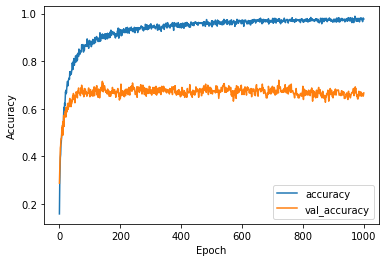

In [15]:
plot_history(history)
model.evaluate(test_X,test_y)